# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
%%javascript

// remove vertical scroll bars from long output cells

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re
# from IPython import display
# from IPython.core.display import HTML
from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import TheilSenRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.datasets import make_classification
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

#%matplotlib notebook
%matplotlib inline

plt.rcParams['figure.dpi'] = 100



C:\Users\lajos\AppData\Local\Temp\ipykernel_25900\2707722991.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# A quick look at the data

In [5]:
def display_dataframe_info(df, df_name):
    """ Display information about a pandas.DataFrame, for example shape, names and types of columns etc.

    Inputs:
      df: the DataFrame
      df_name: the name of the DataFrame to be displayed
    """
    display(HTML('<hr>'))
    display(HTML(f'<h2 style="text-align: center;">{df_name} DataFrame info</h2>'))
    # print(f'---- {df_name} ----')
    print(f'number of rows: {df.shape[0]}')
    print(f'number of cols: {df.shape[1]}')

    display(df.head())

    print('columns:')
    for col in df.columns:
        data_type = df[col].dtype
        num_nan = df[col].isna().sum()
        if num_nan:
            print(f'  {col} ({data_type}, NaN:{num_nan})')
        else:
            print(f'  {col} ({data_type})')
        if data_type==object:
            # print list of values and number of occurance of each value for categorical columns
            try:  # some columns might have unhashable values, for example lists
                values = list(df.groupby(col).groups.keys())
                if len(values)>9:  # if there are too many unique values, skip
                    continue
                print(f'    values:{values}')
                for i,v in df.groupby(col).count().max(axis=1).iteritems():
                    print(f'      {i}: {v}')
            except:
                pass

    display(df.describe())

profile['age'] = profile['age'].replace(118, np.NaN)

display_dataframe_info(portfolio, 'portfolio')
display_dataframe_info(profile, 'profile')
display_dataframe_info(transcript, 'transcript')


number of rows: 10
number of cols: 6


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


columns:
  reward (int64)
  channels (object)
  difficulty (int64)
  duration (int64)
  offer_type (object)
    values:['bogo', 'discount', 'informational']
      bogo: 4
      discount: 4
      informational: 2
  id (object)


,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


number of rows: 17000
number of cols: 5


,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


columns:
  gender (object, NaN:2175)
    values:['F', 'M', 'O']
      F: 6129
      M: 8484
      O: 212
  age (float64, NaN:2175)
  id (object)
  became_member_on (int64)
  income (float64, NaN:2175)


,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


number of rows: 306534
number of cols: 4


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


columns:
  person (object)
  event (object)
    values:['offer completed', 'offer received', 'offer viewed', 'transaction']
      offer completed: 33579
      offer received: 76277
      offer viewed: 57725
      transaction: 138953
  value (object)
  time (int64)


,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


## Data Cleanup and Preparation

The `profile` dataframe has two columns with **NaN** values: **gender** and **income**. The number of **NaN** values are identical in the two columns, suggesting that both columns might have **NaN** values for the same rows only.

Earlier we also replaced the 118 value in the **age** column with **NaN**s.

In [28]:
profile_isna = profile.isna().astype(int)
sum_gender_income_isna = profile_isna.gender + profile_isna.income + profile_isna.age
sum_gender_income_isna.unique()

array([3, 0])

It looks like either **age**, **gender** and **income** all have valid values (0 NaNs), or they are all **NaN** (3 NaNs).

In [29]:
profile[profile['gender'].isna()]

,gender,age,person_id,became_member_on,income,membership_start_day,bins_age,bins_income,income_25k+,income_50k+,...,age__40s,age__50s,age__60s,age__70s,age__80s,age__90s,age_100s,gender_F,gender_M,gender_O
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1294,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,1809,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,1467,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
6,None,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,1519,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
7,None,NaN,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,1526,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16980,None,NaN,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN,1130,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
16982,None,NaN,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN,991,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
16989,None,NaN,ca45ee1883624304bac1e4c8a114f045,20180305,NaN,1680,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
16991,None,NaN,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN,901,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


At this point we have proven that profiule records either have all demographic information, or no demographic information. There are no records with partial demographic info.

However, we'll keep the profiles with missing demographic info at this point because even those records will be useful when we'll look at what is the most effective channel for delivering offers.

The transcript records contain a **time** field in hours. The promotion durations in the profile data set us days as units. We'll convert the timestamps in the transcript records to days to make sure that the same units are used.

In [8]:
# convert transcript time from hours to days, to match portfolio offer duration units
#
transcript.time /= 24

Convert date integers to days from the first registration date in the **profiles** data set.

In [9]:
def convert_date_to_day(x):
    """Convert a date integer from profile record to hours days from the first registration (20130729).
    Input:
      x: date integer (eg. 20171003)

    Output:
      days: days elapsed from 2013/07/29
    """
    x_str = str(x)
    from_date = datetime.date(2013, 7, 29)
    x_date = datetime.date(int(x_str[0:4]), int(x_str[4:6]), int(x_str[6:]))
    delta = x_date - from_date
    return delta.days

# convert date integers to days
#
profile['membership_start_day'] = profile['became_member_on'].apply(convert_date_to_day)


In [10]:
def create_dummy_columns(df, column_name, drop_column=False, prefix=None, prefix_sep='_'):
    """A helper function for creating dummy columns for category values.
    
    Inputs:
      df: a DataFrame
      column_name: the name of the category value column
      drop_column: whether to drop the original category column after creating the dummies
      prefix: if specified, will be used as dummy column prefix (otherwise use column_name)
      prefix_sep: separator to use after prefix

    Returns:
      df: DataFrame with dummy columns created
    """
    if prefix is None:
        prefix = column_name
    print(f'creating dummies for category column: {column_name}')
    # df_category_columns = pd.concat([df_category_columns, df[i]])
    # df_category_columns[i] = df[i]
    df = pd.concat([df if drop_column==False else df.drop(column_name, axis=1), 
                   pd.get_dummies(df[column_name], prefix=prefix, prefix_sep=prefix_sep)], 
                   axis=1)   
    return df 



Create age and income bins for each user in the profiles data set, and dummy columns for each binned value.

In [11]:
# create age bins
#
profile['bins_age']=pd.cut(x=profile.age, 
                            bins=[10,20,30,40,50,60,70,80,90,100,110], 
                            labels=['_10s','_20s','_30s','_40s','_50s','_60s','_70s','_80s','_90s','100s'])

print(profile.bins_age.value_counts().sort_index())

# create income bins
#
profile['bins_income']=pd.cut(x=profile.income, 
                                bins=[25000,50000,75000,100000,125000], 
                                labels=['25k+','50k+','75k+','100k+'])

display(profile.bins_income.value_counts().sort_index())

# create dummy columns for income and age categories
#
profile = create_dummy_columns(profile, 'bins_income', prefix='income')
profile = create_dummy_columns(profile, 'bins_age', prefix='age')
profile = create_dummy_columns(profile, 'gender')

# rename id -> person_id to match the offers DataFrame
#
profile.rename(columns={'id':'person_id'}, inplace=True)

display(profile.head())

_10s     340
_20s    1365
_30s    1597
_40s    2391
_50s    3590
_60s    2910
_70s    1646
_80s     767
_90s     214
100s       5
Name: bins_age, dtype: int64


25k+     4034
50k+     6436
75k+     3349
100k+    1006
Name: bins_income, dtype: int64

creating dummies for category column: bins_income
creating dummies for category column: bins_age
creating dummies for category column: gender


,gender,age,person_id,became_member_on,income,membership_start_day,bins_age,bins_income,income_25k+,income_50k+,...,age__40s,age__50s,age__60s,age__70s,age__80s,age__90s,age_100s,gender_F,gender_M,gender_O
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1294,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1447,_50s,100k+,0,0,...,0,1,0,0,0,0,0,1,0,0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,1809,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1380,_70s,75k+,0,0,...,0,0,0,1,0,0,0,1,0,0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,1467,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


Create dummy columns for the **offer_type** column and the values in the **channels** column of the portfolio data set.

In [12]:
# make dummies for offer types
# 
portfolio = create_dummy_columns(portfolio, 'offer_type')
                            
# make dummies for channels
#
# portfolio = pd.concat([portfolio,
#                         pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0).add_prefix('channel_')],
#                         axis=1)
portfolio = pd.concat([portfolio,
                        pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).groupby(level=0).sum().add_prefix('channel_')],
                        axis=1)
# rename id -> offer_id to match the offers DataFrame
#
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

display(portfolio.head())

creating dummies for category column: offer_type


,reward,channels,difficulty,duration,offer_type,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


Now that we have the profile binned profile columns, let's plot some demographic info.

In [13]:
def rename_binned_index_names(df):
    """Utility function to remove prefixes from binned index labels.
    eg. 
      age_10s -> 10s
      income_10k+ -> 10k+
    
    Input:
      df: DataFrame to process
      
    Output:
      df: DataFrame with prefixes removed from index labels"""
    new_index_names = {}
    for i in list(df.index):
        new_index_names[i] = i.split('_')[-1]
    df.rename(index=new_index_names, inplace=True)
    return df

# create lists for offer and bin column names for easy filtering.
#
age_column_names = [s for s in list(profile.columns) if re.compile('^age_').match(s)]
income_column_names = [s for s in list(profile.columns) if re.compile('^income_').match(s)]
gender_column_names = [s for s in list(profile.columns) if re.compile('^gender_').match(s)]

offer_column_names = ['offer_viewed', 'offer_completed', 'offer_type', 'transaction_count', 'transaction_total']

print(f'age column names: {age_column_names}')
print(f'income column names: {income_column_names}')
print(f'gender column names: {gender_column_names}')
print(f'offer column names: {offer_column_names}')

age column names: ['age__10s', 'age__20s', 'age__30s', 'age__40s', 'age__50s', 'age__60s', 'age__70s', 'age__80s', 'age__90s', 'age_100s']
income column names: ['income_25k+', 'income_50k+', 'income_75k+', 'income_100k+']
gender column names: ['gender_F', 'gender_M', 'gender_O']
offer column names: ['offer_viewed', 'offer_completed', 'offer_type', 'transaction_count', 'transaction_total']


<AxesSubplot:title={'center':'Profiles by Age'}, xlabel='Age', ylabel='Number of Profiles'>

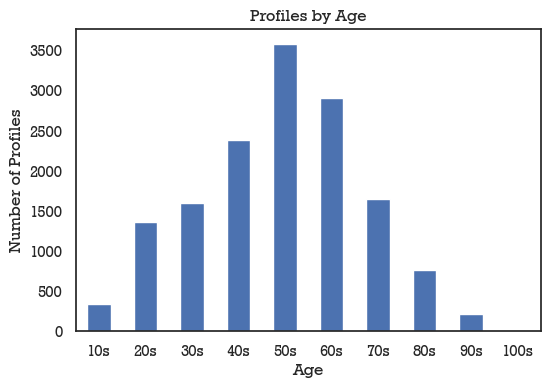

<AxesSubplot:title={'center':'Profiles by Gender'}, xlabel='Gender', ylabel='Number of Profiles'>

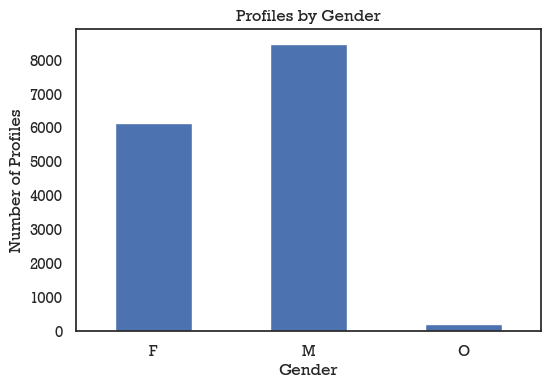

<AxesSubplot:title={'center':'Profiles by Income'}, xlabel='Income', ylabel='Number of Profiles'>

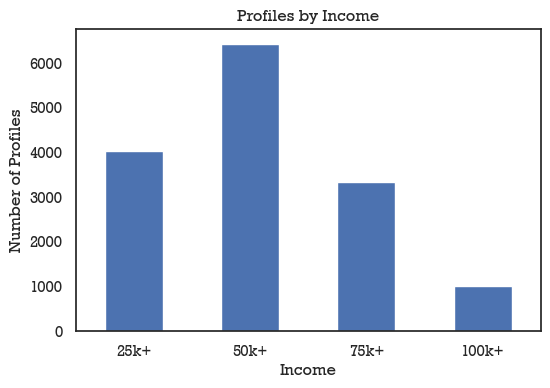

In [14]:
sns.set_theme()
sns.set(style='white', font='Rockwell')
pal = sns.color_palette('deep',1)    

display(rename_binned_index_names(profile[age_column_names].sum()).plot.bar(title='Profiles by Age', 
                                                                            xlabel='Age',
                                                                            ylabel='Number of Profiles',
                                                                            rot=0, color=pal))
plt.show()

display(rename_binned_index_names(profile[gender_column_names].sum()).plot.bar(title='Profiles by Gender', 
                                                                               xlabel='Gender',
                                                                               ylabel='Number of Profiles',
                                                                               rot=0, color=pal))
plt.show()

display(rename_binned_index_names(profile[income_column_names].sum()).plot.bar(title='Profiles by Income', 
                                                                               xlabel='Income',
                                                                               ylabel='Number of Profiles',
                                                                               rot=0, color=pal))
plt.show()



### Parsing Offer Records

Currently transactions, information about promotions and demographic info about customers are in separate tables.

We need to combine all these tables and find purchase transactions that were influenced by promotions.

Unfortunately transactions don't indicate whether purchases are tied to a specific promotion, so we'll have to assume that after a customer receives and views a promotion, the purchases belong to that offer until the offer completes or expires.

We'll use the code below to parse all offers. For each offer, we'll record:
- **person_id** - id of the person who received the offer
- **offer_id** - id of the offer matching the portfolio dataset
- **start_date** - date of offer received, in days after estart of experiment
- **end_date** - date offer expires, in days after estart of experiment
- **viewed** - whether the offer was viewed
- **completed** - wheteher the offer was completed
- **transaction_count** - number of sales tied to this offer
- **transaction_total** - purchase total


In [15]:
class OfferRecord:
    """This class is used to store information about an offer given to a customer."""
    def __init__(self, person_id, offer_id, date, duration):
        """Initializes an OfferRecord instance.
        Inputs: 
          person_id: id of customer
          offer_id: id of offer
          date: date offer is received (in days)
          duration: how long this offer is valid for (in days)
        """
        self.person_id = person_id
        self.offer_id = offer_id
        self.start_date = date
        self.end_date = self.start_date + duration
        self.viewed = 0
        self.completed = 0
        self.transaction_count = 0
        self.transaction_total = 0

    def as_dict(self):
        """Returns an OfferRecord as a python dict.
        Returns:
          dict: a python dictionary with the offer's properties
        """
        d = {}
        d['person_id'] = self.person_id
        d['offer_id'] = self.offer_id
        d['offer_viewed'] = self.viewed
        d['offer_completed'] = self.completed
        d['offer_start_date'] = self.start_date
        d['offer_end_date'] = self.end_date
        d['transaction_count'] = self.transaction_count
        d['transaction_total'] = self.transaction_total
        return(d)

    def __str__(self):
        """Returns a python string representation of the class, usually used to print the object."""
        return(f'{self.person_id} {self.offer_id} {self.start_date} {self.end_date} {self.viewed} {self.completed} {self.transaction_count} {self.transaction_total}')

def parse_offer_records(customer_transcript, portfolio):
    """
    Parses transcript records for offers a customer received and used.

    Inputs:
      customer_transcript: DataFrame containing all transcript records for a customer id, in chronological order
      portfolio: the portfolio DataFrame (used to get info about offers)

    Returns:
      offer_records: a list of offers records for the customer id
    """
    offer_record = None
    offer_records = []
    for i in range(len(customer_transcript)):
        r = customer_transcript.iloc[i]
        if r.event == 'offer received':
            if offer_record is not None:
                offer_records.append(offer_record)
            offer_id = r.value['offer id']
            offer_duration = portfolio.loc[portfolio.offer_id==offer_id].duration.item()
            offer_record = OfferRecord(r.person, offer_id, r.time, offer_duration)
        elif r.event == 'offer viewed':
            if r.value['offer id'] != offer_record.offer_id:
                print(f'offer id mismatch (viewed): person:{offer_record.person_id} {offer_record.offer_id} {r.value["offer id"]}')
            offer_record.viewed = 1
        elif r.event == 'offer completed':
            if offer_record.viewed and r.value['offer_id'] == offer_record.offer_id:
                offer_record.completed = 1
        elif r.event == 'transaction':
            if offer_record and offer_record.viewed and r.time<=offer_record.end_date:
                offer_record.transaction_count += 1
                offer_record.transaction_total += r.value['amount']
        
    if offer_record is not None:
        offer_records.append(offer_record)
            
    return offer_records



In [16]:
if not os.path.exists('data/offers.pkl'):
    offer_records = []

    for i in tqdm(range(len(profile))):
        customer = profile.iloc[i]
        customer_id = customer.person_id

        customer_transcript = transcript.loc[transcript.person==customer_id]

        for o in parse_offer_records(customer_transcript, portfolio):
            offer_records.append(o.as_dict())

    print(f'number of offer records parsed: {len(offer_records)}')

    offers = pd.DataFrame.from_records(offer_records)

    print('pickle offers data')
    offers.to_pickle('data/offers.pkl')

print('unpickle offers data')
offers = pd.read_pickle('data/offers.pkl')

unpickle offers data


Merge the **portfolio** and **profile** records into the **offers** data set.

In [17]:
offers = pd.merge(offers, profile, on='person_id')
offers = pd.merge(offers, portfolio, on='offer_id')

print(f'offers shape: {offers.shape}')
display(offers.head())

offers shape: (76277, 44)


,person_id,offer_id,offer_viewed,offer_completed,offer_start_date,offer_end_date,transaction_count,transaction_total,gender,age,...,difficulty,duration,offer_type,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,channel_web
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,1,0,7.0,14.0,0,0.0,None,NaN,...,10,7,discount,0,1,0,1,1,0,1
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,0,0.0,7.0,0,0.0,M,68.0,...,10,7,discount,0,1,0,1,1,0,1
2,8ec6ce2a7e7949b1bf142def7d0e0586,2906b810c7d4411798c6938adc9daaa5,1,0,17.0,24.0,0,0.0,None,NaN,...,10,7,discount,0,1,0,1,1,0,1
3,68617ca6246f4fbc85e91a2a49552598,2906b810c7d4411798c6938adc9daaa5,1,0,17.0,24.0,0,0.0,None,NaN,...,10,7,discount,0,1,0,1,1,0,1
4,389bc3fa690240e798340f5a15918d5c,2906b810c7d4411798c6938adc9daaa5,1,0,14.0,21.0,0,0.0,M,65.0,...,10,7,discount,0,1,0,1,1,0,1


## Demographics Based Offer Analysis

We are trying to find out which offer works best for different demographics, so now we can remove profiles from the data set with **NaN** values because we proved earler that profile records with **NaN**s are missing all demographics info.

In [18]:
print(f'offers number of rows: {offers.shape[0]}')

#save all records for later
offers_all = offers.copy()

# drop records with NaNs
offers.dropna(inplace=True)

print(f'offers number of rows: {offers_all.shape[0]}')
print(f'offers number of rows after dropping NaNs: {offers.shape[0]}')

offers number of rows: 76277
offers number of rows: 76277
offers number of rows after dropping NaNs: 66501


number of offers sent: 26537
number of offers not viewed: 4498
number of offers viewed: 22039
number of offers completed: 9687


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
10s,637,521,145,100,81.789639,22.762951,6.572222,11.607143
20s,2440,1985,628,100,81.352459,25.737705,8.793507,15.734611
30s,2833,2339,935,100,82.562654,33.003883,10.357227,17.614232
40s,4309,3691,1668,100,85.657925,38.709677,13.633256,19.464328
50s,6420,5305,2499,100,82.632399,38.925234,16.356842,21.113575
60s,5218,4289,1966,100,82.196244,37.677271,15.687736,19.761497
70s,2944,2443,1142,100,82.982337,38.790761,16.113625,20.339073
80s,1326,1126,537,100,84.917044,40.497738,15.767035,20.856244
90s,408,338,165,100,82.843137,40.441176,16.481094,20.682157
100s,2,2,2,100,100.000000,100.000000,19.576667,29.365000


<AxesSubplot:title={'center':'BOGO Offers by Age'}>

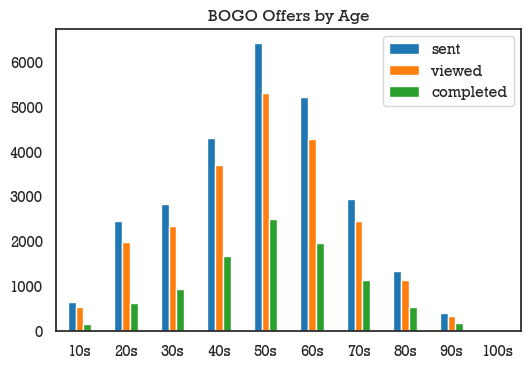

<AxesSubplot:title={'center':'BOGO Offers by Age'}>

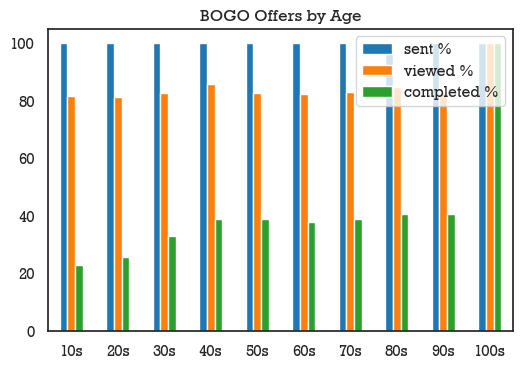

<AxesSubplot:title={'center':'BOGO Offers by Age'}>

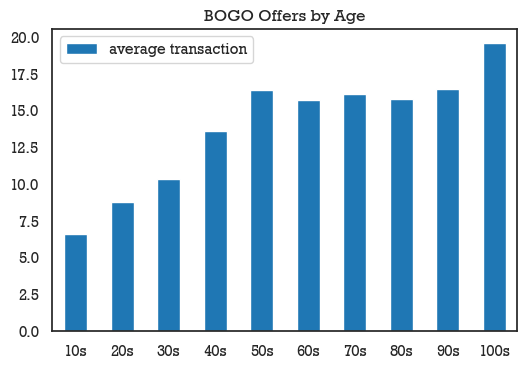

<AxesSubplot:title={'center':'BOGO Offers by Age'}>

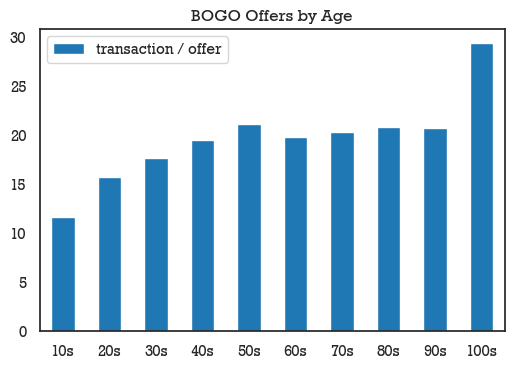

number of offers sent: 26537
number of offers not viewed: 4498
number of offers viewed: 22039
number of offers completed: 9687


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
F,10975,9143,4765,100,83.307517,43.416856,17.492201,23.371811
M,15208,12581,4750,100,82.726197,31.233561,11.307388,16.410137
O,354,315,172,100,88.983051,48.587571,14.331734,23.117006


<AxesSubplot:title={'center':'BOGO Offers by Gender'}>

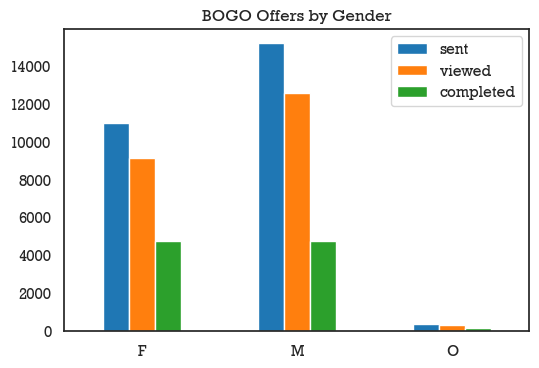

<AxesSubplot:title={'center':'BOGO Offers by Gender'}>

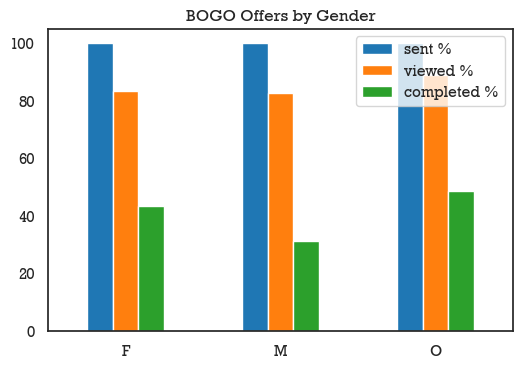

<AxesSubplot:title={'center':'BOGO Offers by Gender'}>

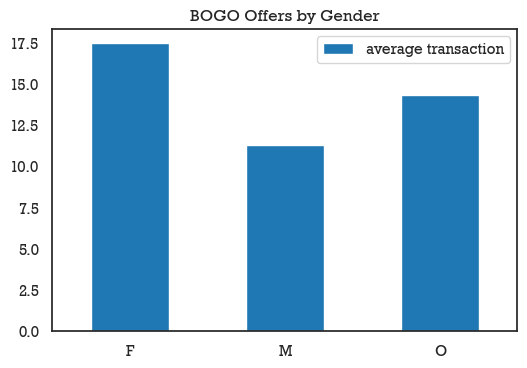

<AxesSubplot:title={'center':'BOGO Offers by Gender'}>

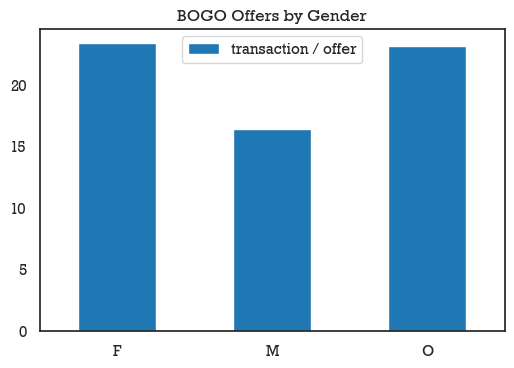

number of offers sent: 26537
number of offers not viewed: 4498
number of offers viewed: 22039
number of offers completed: 9687


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
25k+,7254,5820,1727,100,80.231596,23.807554,6.825615,11.829560
50k+,11500,9801,4328,100,85.226087,37.634783,12.497289,18.524243
75k+,5959,5039,2818,100,84.561168,47.289814,27.092164,27.392229
100k+,1824,1379,814,100,75.603070,44.627193,31.379254,28.609485


<AxesSubplot:title={'center':'BOGO Offers by Income'}>

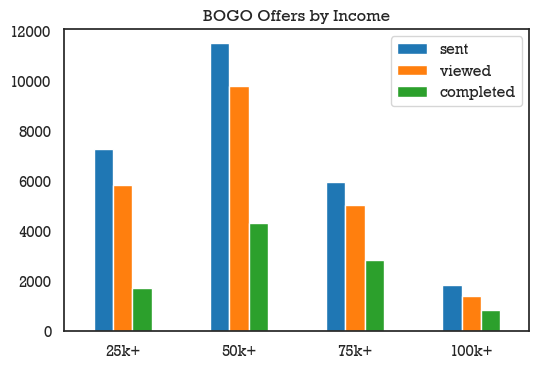

<AxesSubplot:title={'center':'BOGO Offers by Income'}>

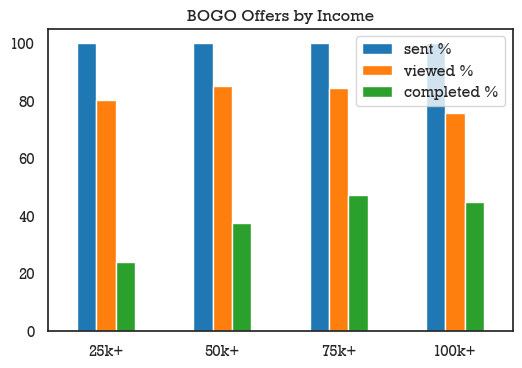

<AxesSubplot:title={'center':'BOGO Offers by Income'}>

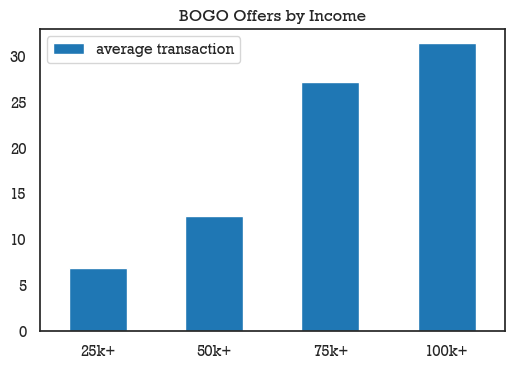

<AxesSubplot:title={'center':'BOGO Offers by Income'}>

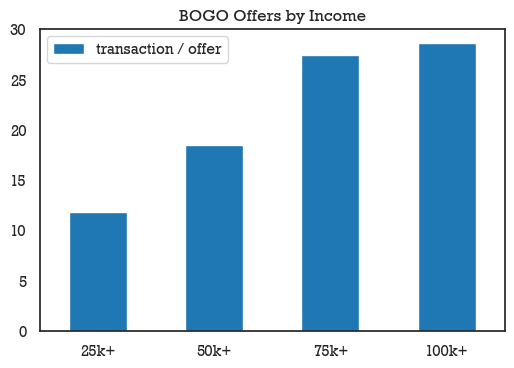

number of offers sent: 26664
number of offers not viewed: 8203
number of offers viewed: 18461
number of offers completed: 9890


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
10s,563,330,155,100,58.614565,27.531083,8.660478,13.183002
20s,2547,1520,719,100,59.678053,28.229289,8.150670,12.522014
30s,2939,1951,1035,100,66.383124,35.216060,10.382795,16.529806
40s,4189,3056,1642,100,72.952972,39.197899,14.120447,18.998052
50s,6484,4552,2484,100,70.203578,38.309685,17.290619,21.631940
60s,5287,3798,2065,100,71.836580,39.058067,16.827827,22.200509
70s,2918,2035,1121,100,69.739548,38.416724,17.820666,21.900243
80s,1350,951,527,100,70.444444,39.037037,18.630410,24.260933
90s,373,259,136,100,69.436997,36.461126,18.370588,21.768901
100s,14,9,6,100,64.285714,42.857143,19.169583,32.862143


<AxesSubplot:title={'center':'Discount Offers by Age'}>

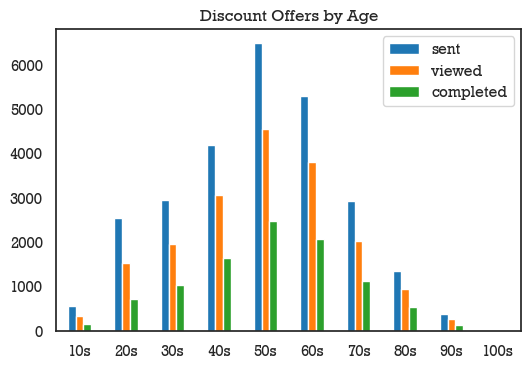

<AxesSubplot:title={'center':'Discount Offers by Age'}>

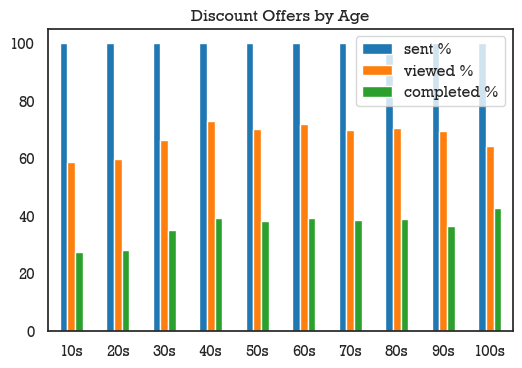

<AxesSubplot:title={'center':'Discount Offers by Age'}>

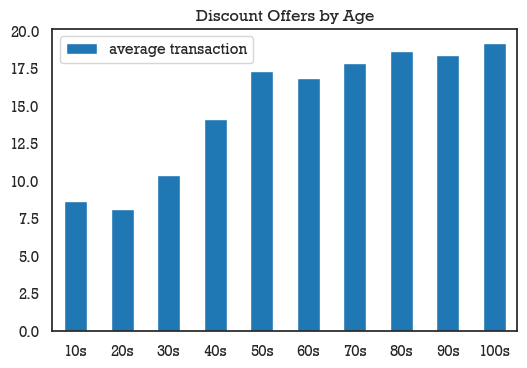

<AxesSubplot:title={'center':'Discount Offers by Age'}>

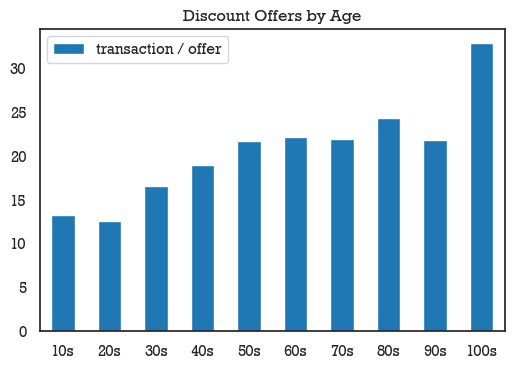

number of offers sent: 26664
number of offers not viewed: 8203
number of offers viewed: 18461
number of offers completed: 9890


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
F,10943,7733,4517,100,70.666179,41.277529,17.901514,24.186592
M,15354,10431,5208,100,67.936694,33.919500,12.417766,16.700981
O,367,297,165,100,80.926431,44.959128,16.913035,25.208256


<AxesSubplot:title={'center':'Discount Offers by Gender'}>

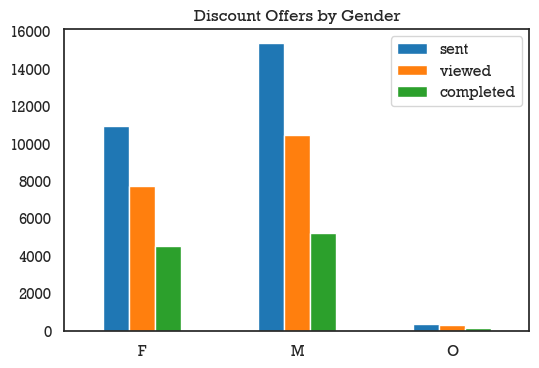

<AxesSubplot:title={'center':'Discount Offers by Gender'}>

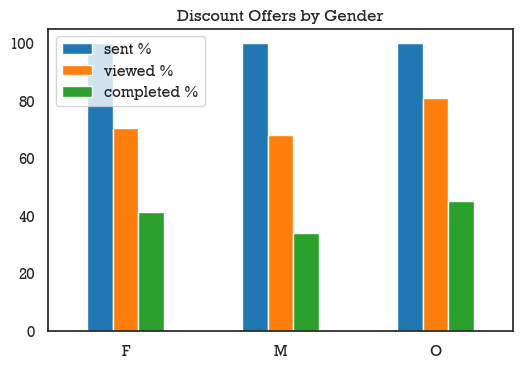

<AxesSubplot:title={'center':'Discount Offers by Gender'}>

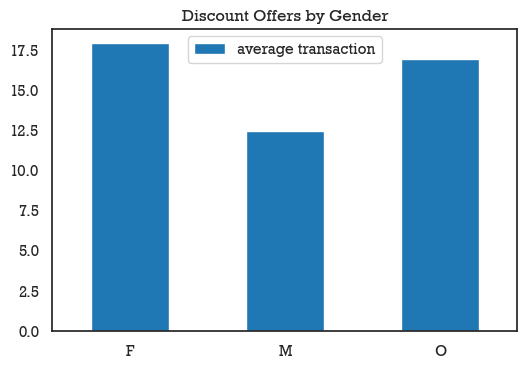

<AxesSubplot:title={'center':'Discount Offers by Gender'}>

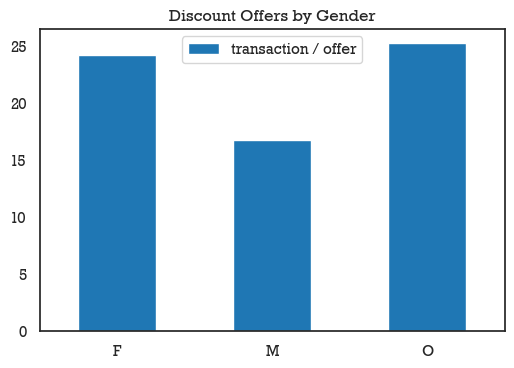

number of offers sent: 26664
number of offers not viewed: 8203
number of offers viewed: 18461
number of offers completed: 9890


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
25k+,7268,4324,2016,100,59.493671,27.738030,7.051803,10.376862
50k+,11588,8340,4454,100,71.971004,38.436313,13.067720,18.831365
75k+,5995,4677,2736,100,78.015013,45.638032,26.763306,30.410616
100k+,1813,1120,684,100,61.776062,37.727523,30.632680,30.007523


<AxesSubplot:title={'center':'Discount Offers by Income'}>

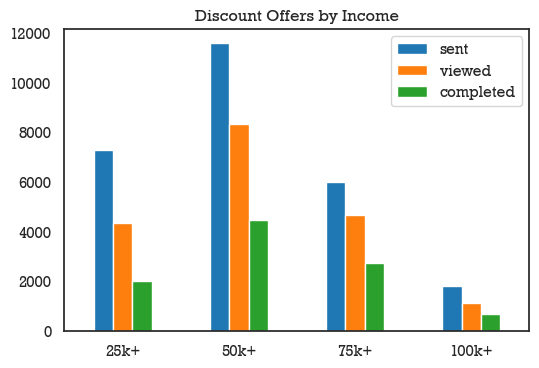

<AxesSubplot:title={'center':'Discount Offers by Income'}>

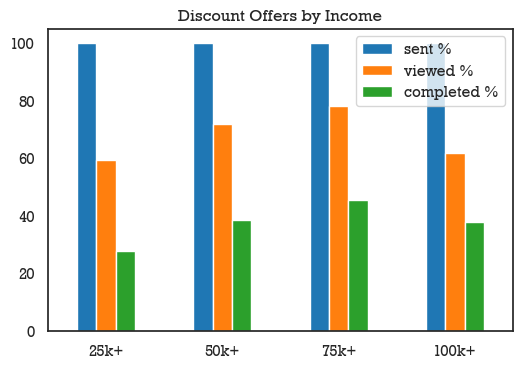

<AxesSubplot:title={'center':'Discount Offers by Income'}>

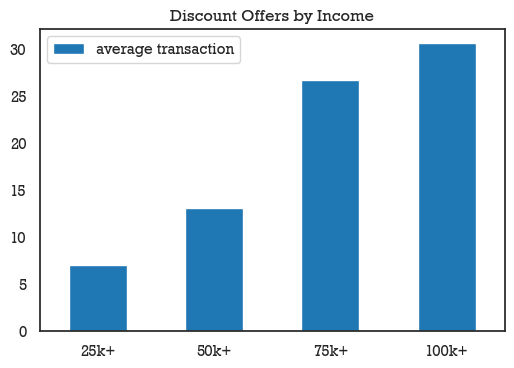

<AxesSubplot:title={'center':'Discount Offers by Income'}>

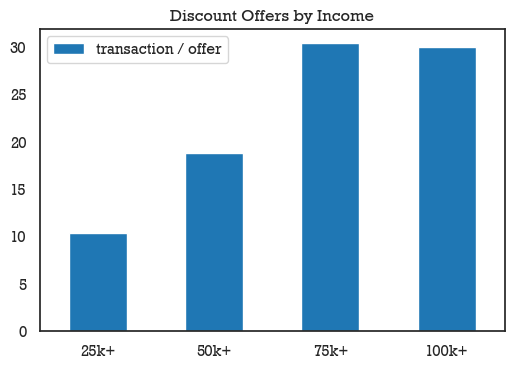

number of offers sent: 13300
number of offers not viewed: 3940
number of offers viewed: 9360
number of offers completed: 0


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
10s,308,211,0.0,100,68.506494,0.0,7.655227,6.561623
20s,1193,758,0.0,100,63.537301,0.0,8.340526,6.774493
30s,1430,996,0.0,100,69.650350,0.0,11.381854,8.970175
40s,2128,1597,0.0,100,75.046992,0.0,14.101547,9.383360
50s,3273,2340,0.0,100,71.494042,0.0,15.554515,9.903944
60s,2557,1778,0.0,100,69.534611,0.0,15.210840,9.202648
70s,1470,1036,0.0,100,70.476190,0.0,16.149411,10.074156
80s,739,513,0.0,100,69.418133,0.0,14.098361,9.080947
90s,195,126,0.0,100,64.615385,0.0,13.086696,7.717795
100s,7,5,0.0,100,71.428571,0.0,24.394000,17.424286


<AxesSubplot:title={'center':'Informational Offers by Age'}>

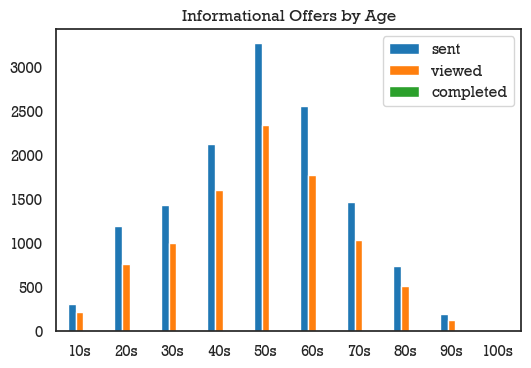

<AxesSubplot:title={'center':'Informational Offers by Age'}>

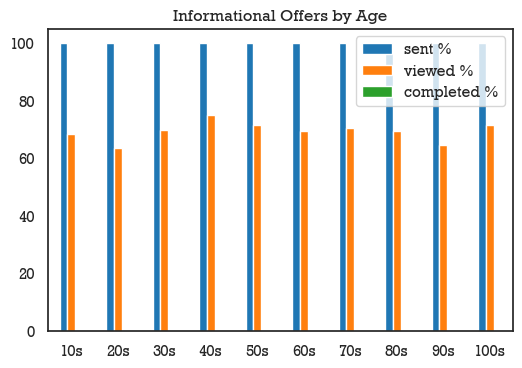

<AxesSubplot:title={'center':'Informational Offers by Age'}>

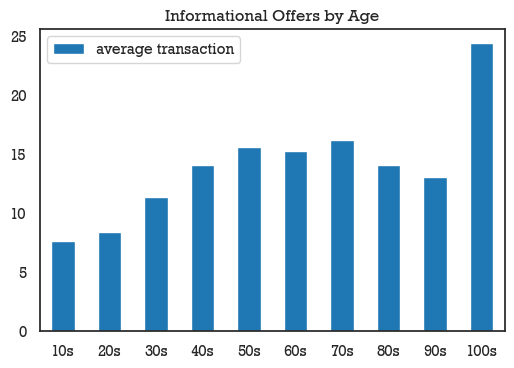

<AxesSubplot:title={'center':'Informational Offers by Age'}>

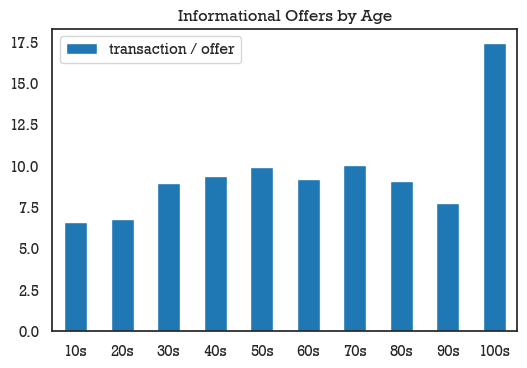

number of offers sent: 13300
number of offers not viewed: 3940
number of offers viewed: 9360
number of offers completed: 0


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
F,5538,3910,0.0,100,70.603106,0.0,17.008838,10.810962
M,7567,5289,0.0,100,69.895599,0.0,11.318586,7.867816
O,195,161,0.0,100,82.564103,0.0,18.462643,13.255231


<AxesSubplot:title={'center':'Informational Offers by Gender'}>

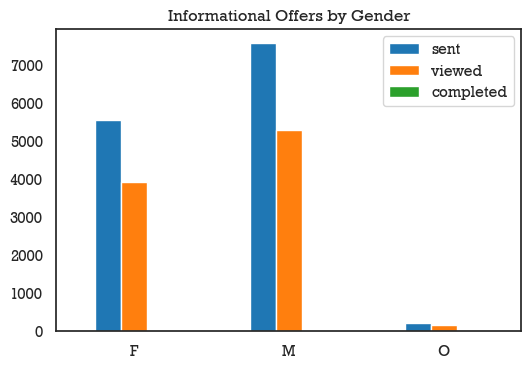

<AxesSubplot:title={'center':'Informational Offers by Gender'}>

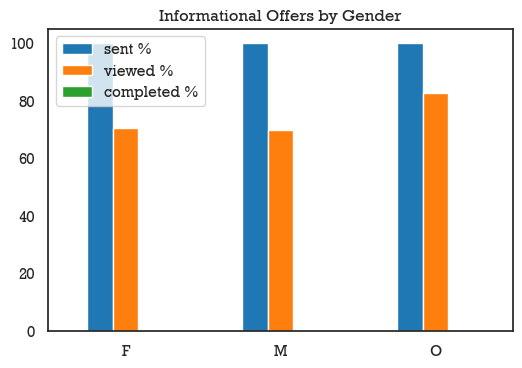

<AxesSubplot:title={'center':'Informational Offers by Gender'}>

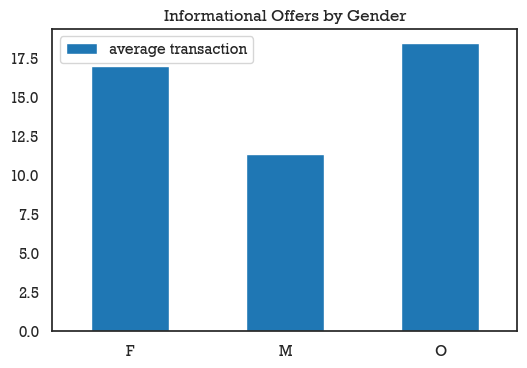

<AxesSubplot:title={'center':'Informational Offers by Gender'}>

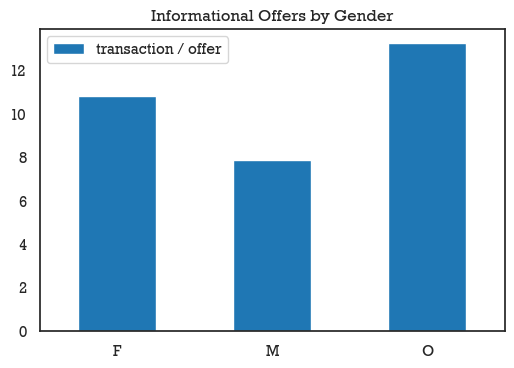

number of offers sent: 13300
number of offers not viewed: 3940
number of offers viewed: 9360
number of offers completed: 0


,sent,viewed,completed,sent %,viewed %,completed %,average transaction,transaction / offer
25k+,3589,2301,0.0,100,64.112566,0.0,6.866838,5.349590
50k+,5823,4332,0.0,100,74.394642,0.0,13.166077,9.810683
75k+,2999,2229,0.0,100,74.324775,0.0,24.910757,12.401387
100k+,889,498,0.0,100,56.017998,0.0,29.015719,9.530472


<AxesSubplot:title={'center':'Informational Offers by Income'}>

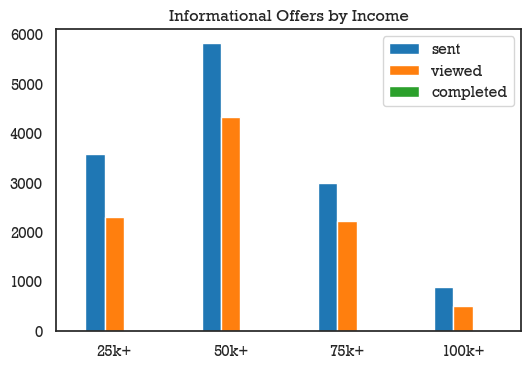

<AxesSubplot:title={'center':'Informational Offers by Income'}>

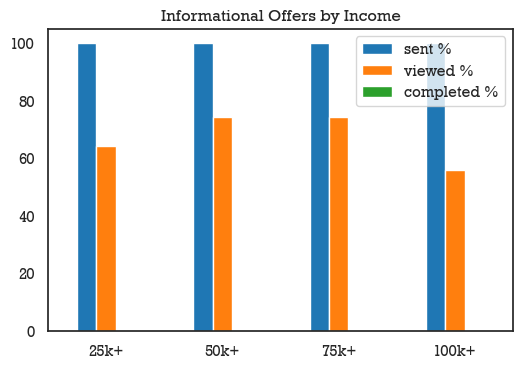

<AxesSubplot:title={'center':'Informational Offers by Income'}>

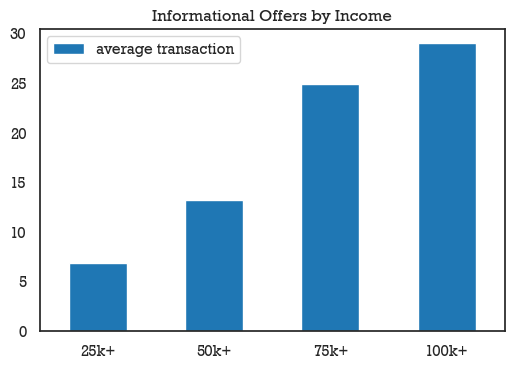

<AxesSubplot:title={'center':'Informational Offers by Income'}>

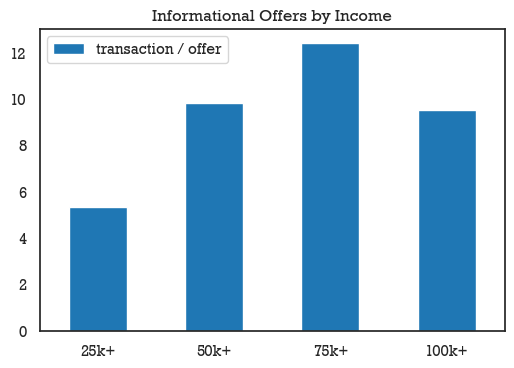

In [19]:
def bar_plot_offer_columns(o, cols, title):
    """Print statistics and plot graph from specific offer columns.
    
    Inputs:
      o: offers DataFrame
      cols: list of columns to show
      title: title for plots
      
    Returns:
      offer_count_by_col: DataFrame woth offer stats per columns"""

    display(HTML('<hr>'))
    display(HTML(f'<h2 style="text-align: center;">{title}</h2>'))

    print(f'number of offers sent: {o[cols].shape[0]}')
    print(f'number of offers not viewed: {o.loc[o.offer_viewed==False][cols].shape[0]}')
    print(f'number of offers viewed: {o.loc[o.offer_viewed==True][cols].shape[0]}')
    print(f'number of offers completed: {o.loc[o.offer_completed==True][cols].shape[0]}')

    offer_count_by_col = pd.DataFrame()

    offer_count_by_col['sent'] = o[cols].sum()
    offer_count_by_col['viewed'] = o.loc[o.offer_viewed==1][cols].sum()
    offer_count_by_col['completed'] = o.loc[o.offer_completed==1][cols].sum()

    offer_count_by_col['sent %'] = 100
    offer_count_by_col['viewed %'] = offer_count_by_col['viewed'] / offer_count_by_col['sent'] * 100
    offer_count_by_col['completed %'] = offer_count_by_col['completed'] / offer_count_by_col['sent'] * 100

    offer_count_by_col['tcount'] = o[cols].multiply(o.transaction_count, axis=0).sum()
    offer_count_by_col['ttotal'] = o[cols].multiply(o.transaction_total, axis=0).sum()
    offer_count_by_col['average transaction'] = offer_count_by_col['ttotal'] / offer_count_by_col['tcount']
    offer_count_by_col['transaction / offer'] = offer_count_by_col['ttotal'] / offer_count_by_col['sent']
    offer_count_by_col.drop(columns=['tcount', 'ttotal'], inplace=True)

    offer_count_by_col = rename_binned_index_names(offer_count_by_col)

    display(offer_count_by_col)

    sns.set_theme()
    sns.set(style='white', font='Rockwell')
    pal = sns.color_palette('tab10')    


    display(offer_count_by_col[['sent', 'viewed', 'completed']].plot.bar(title=title, rot=0, color=pal))
    plt.show()

    display(offer_count_by_col[['sent %', 'viewed %', 'completed %']].plot.bar(title=title, rot=0, color=pal))
    plt.show()

    display(offer_count_by_col[['average transaction']].plot.bar(title=title, rot=0, color=pal))
    plt.show()

    display(offer_count_by_col[['transaction / offer']].plot.bar(title=title, rot=0, color=pal))
    plt.show()

    return offer_count_by_col


offers_by_age = pd.DataFrame()
offers_by_gender = pd.DataFrame()
offers_by_income = pd.DataFrame()

df = bar_plot_offer_columns(offers.loc[offers.offer_type=='bogo'], age_column_names, 'BOGO Offers by Age')
offers_by_age['bogo'] = df['transaction / offer']
df = bar_plot_offer_columns(offers.loc[offers.offer_type=='bogo'], gender_column_names, 'BOGO Offers by Gender')
offers_by_gender['bogo'] = df['transaction / offer']
df = bar_plot_offer_columns(offers.loc[offers.offer_type=='bogo'], income_column_names, 'BOGO Offers by Income')
offers_by_income['bogo'] = df['transaction / offer']

df = bar_plot_offer_columns(offers.loc[offers.offer_type=='discount'], age_column_names, 'Discount Offers by Age')
offers_by_age['discount'] = df['transaction / offer']
df = bar_plot_offer_columns(offers.loc[offers.offer_type=='discount'], gender_column_names, 'Discount Offers by Gender')
offers_by_gender['discount'] = df['transaction / offer']
df = bar_plot_offer_columns(offers.loc[offers.offer_type=='discount'], income_column_names, 'Discount Offers by Income')
offers_by_income['discount'] = df['transaction / offer']

df = bar_plot_offer_columns(offers.loc[offers.offer_type=='informational'], age_column_names, 'Informational Offers by Age')
offers_by_age['informational'] = df['transaction / offer']
df = bar_plot_offer_columns(offers.loc[offers.offer_type=='informational'], gender_column_names, 'Informational Offers by Gender')
offers_by_gender['informational'] = df['transaction / offer']
df = bar_plot_offer_columns(offers.loc[offers.offer_type=='informational'], income_column_names, 'Informational Offers by Income')
offers_by_income['informational'] = df['transaction / offer']


Plot average transaction of offer types for demographic features.

<AxesSubplot:title={'center':'Offer Types by Age'}, xlabel='Age', ylabel='Average Transaction / Offer'>

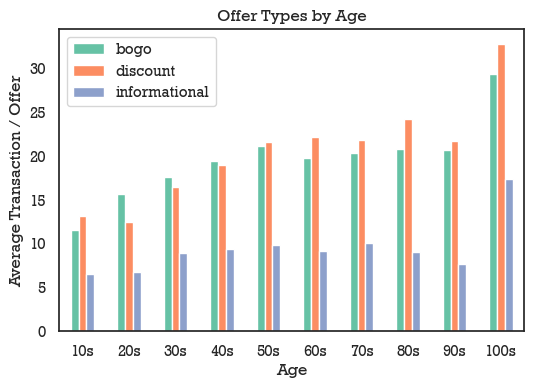

,bogo,discount,informational
F,23.371811,24.186592,10.810962
M,16.410137,16.700981,7.867816
O,23.117006,25.208256,13.255231


<AxesSubplot:title={'center':'Offer Types by Gender'}, xlabel='Age', ylabel='Average Transaction / Offer'>

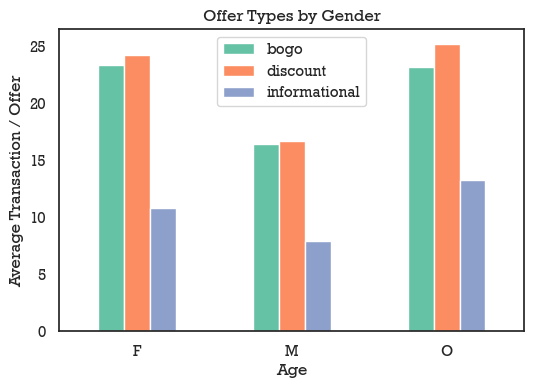

,bogo,discount,informational
25k+,11.829560,10.376862,5.349590
50k+,18.524243,18.831365,9.810683
75k+,27.392229,30.410616,12.401387
100k+,28.609485,30.007523,9.530472


<AxesSubplot:title={'center':'Offer Types by Income'}, xlabel='Age', ylabel='Average Transaction / Offer'>

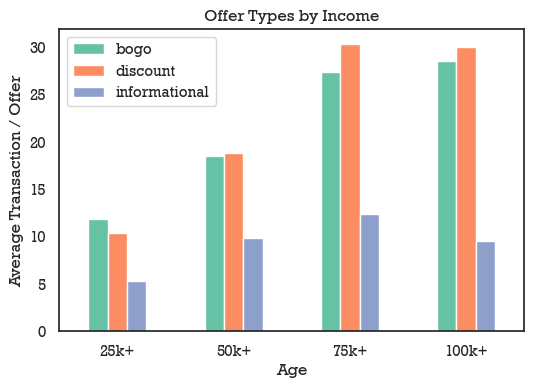

In [30]:
sns.set_theme()
sns.set(style='white', font='Rockwell')
pal = sns.color_palette('Set2')    


# display(offers_by_age)
display(offers_by_age.plot.bar(title='Offer Types by Age', rot=0, xlabel='Age', ylabel='Average Transaction / Offer' ,color=pal))
plt.show()

display(offers_by_gender)
display(offers_by_gender.plot.bar(title='Offer Types by Gender', rot=0, xlabel='Age', ylabel='Average Transaction / Offer' ,color=pal))
plt.show()

display(offers_by_income)
display(offers_by_income.plot.bar(title='Offer Types by Income', rot=0, xlabel='Age', ylabel='Average Transaction / Offer' ,color=pal))
plt.show()


# Most Effective Channel Analysis

We'll perform linear regression analysis on all offer records to find out which delivery channel results in offers being viewed.

In [21]:
channel_column_names = [s for s in list(offers_all.columns) if re.compile('^channel_').match(s)]

print(f'channel bin column names: {channel_column_names}')

channel bin column names: ['channel_email', 'channel_mobile', 'channel_social', 'channel_web']


Create the data sets for the linear regression model. We only need the columns with the offer channels information and the column indicating whather the offer was viewed.

In [22]:
X = offers_all[channel_column_names]
y = offers_all['offer_viewed']

# remove channel_ prefix from column names
channel_col_map = {}
for i in channel_column_names:
    channel_col_map[i] = i.split('_')[-1]
X.rename(columns=channel_col_map)

display(X)
display(y)

,channel_email,channel_mobile,channel_social,channel_web
0,1,1,0,1
1,1,1,0,1
2,1,1,0,1
3,1,1,0,1
4,1,1,0,1
...,...,...,...,...
76272,1,1,1,1
76273,1,1,1,1
76274,1,1,1,1
76275,1,1,1,1


0        1
1        1
2        1
3        1
4        1
        ..
76272    1
76273    1
76274    1
76275    1
76276    1
Name: offer_viewed, Length: 76277, dtype: int64

Fit a linear regression model to the data using a Theil-Sen estimator

In [23]:

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

print('X shape:', X_train.shape)

# use the Theil-Sen estimator to fit a linear model
# https://en.wikipedia.org/wiki/Theil%E2%80%93Sen_estimator

best_model = None
best_score = 0

parameter_grid = {
    'n_subsamples': [10, 20, 100, 1000],
    'max_subpopulation': [500, 1000, 2000, 5000]
}

parameter_search_results = np.zeros((len(parameter_grid['n_subsamples']),len(parameter_grid['max_subpopulation'])), dtype=np.float64)

print('-----------')
for i in range(len(parameter_grid['n_subsamples'])):
    n_subsamples = parameter_grid['n_subsamples'][i]
    for o in range(len(parameter_grid['max_subpopulation'])):
        max_subpopulation = parameter_grid['max_subpopulation'][o]
        lm_model = TheilSenRegressor(random_state=42, n_subsamples=n_subsamples, fit_intercept=True, verbose=False, max_subpopulation=max_subpopulation)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        test_score = r2_score(y_test, y_test_preds)
        if test_score > best_score:
            best_score = test_score
            best_model = lm_model
        print(f'max_iter: {n_subsamples}, max_subpopulation: {max_subpopulation}, test_score:{test_score}')
        np.put(parameter_search_results, (i + o*len(parameter_grid['n_subsamples'])), test_score)
print('-----------')

print(f'best model: {best_model}')
print(f'best score: {best_score}')

# predict
y_test_preds = best_model.predict(X_test)
y_train_preds = best_model.predict(X_train)

# score
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

# print(train_score, test_score)

X shape: (57207, 4)
-----------
max_iter: 10, max_subpopulation: 500, test_score:0.2713225242905605
max_iter: 10, max_subpopulation: 1000, test_score:0.2710765429311155
max_iter: 10, max_subpopulation: 2000, test_score:0.2710377892697746
max_iter: 10, max_subpopulation: 5000, test_score:0.2709240192964365
max_iter: 20, max_subpopulation: 500, test_score:0.27224338131664194
max_iter: 20, max_subpopulation: 1000, test_score:0.27237367416937386
max_iter: 20, max_subpopulation: 2000, test_score:0.27224673009200073
max_iter: 20, max_subpopulation: 5000, test_score:0.2723198176052991
max_iter: 100, max_subpopulation: 500, test_score:0.2726148903446448
max_iter: 100, max_subpopulation: 1000, test_score:0.27268170589230745
max_iter: 100, max_subpopulation: 2000, test_score:0.272759088935678
max_iter: 100, max_subpopulation: 5000, test_score:0.2727504110224328
max_iter: 1000, max_subpopulation: 500, test_score:0.2726526144413284
max_iter: 1000, max_subpopulation: 1000, test_score:0.272704082550

[Text(0.5, 17.25, 'n_subsamples'),
 Text(42.25, 0.5, 'max_subpopulation'),
 Text(0.5, 1.0, 'Theil-Sen Estimator Parameters')]

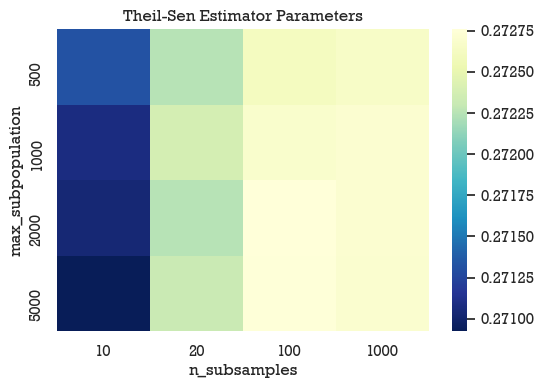

In [24]:
s = sns.heatmap(parameter_search_results,
                xticklabels = parameter_grid['n_subsamples'],
                yticklabels = parameter_grid['max_subpopulation'],
                cmap='YlGnBu_r')
s.set(xlabel='n_subsamples', ylabel='max_subpopulation', title='Theil-Sen Estimator Parameters')

Plot the predictions from the linear regression model.

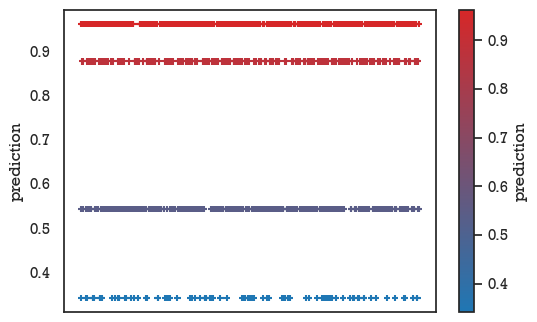

In [25]:
#create a scatter plot to show distribution of predicted values
y_all = np.concatenate((y_train_preds, y_test_preds), axis=0)
df_y_all = pd.DataFrame(y_all, columns=['prediction'])
df_y_all['x'] = offers_all.index

ch = sns.color_palette("tab10").as_hex()
ch1 = ch[0]
ch2 = ch[3]
pal = sns.color_palette(f'blend:{ch1},{ch2}', as_cmap=True) 

plot = df_y_all[:1000].plot.scatter(x='x', y='prediction', marker='+', c='prediction', colormap=pal)

How does each channel contribute to the offer being viewed?

In [26]:
def get_model_coefficients(coefficients, variable_names, drop_variable_names=None):
    '''
    INPUT:
    coefficients - the coefficients of the linear model
    variable_names - names of variables corresponding to coefficients
    drop_variable_names - drop variables with these names (useful for removing poly offset)
    OUTPUT:
    df_c - a dataframe holding the coefficient and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    df_c = pd.DataFrame()
    df_c['column'] =  variable_names
    df_c['weight'] = lm_model.coef_
    df_c['abs(weight)'] = np.abs(lm_model.coef_)
    for i in drop_variable_names:
        df_c = df_c.drop(labels=list(df_c.index[df_c['column']==i]), axis=0)
    df_c = df_c.sort_values('abs(weight)', ascending=False)
    return df_c

#display coefficients of fitted model
df_c = get_model_coefficients(lm_model.coef_, list(X_train.columns), drop_variable_names=['poly_offset'])
pal = sns.color_palette("pastel").as_hex()
df_c.style.bar(subset=['weight'], color=[pal[3], pal[2]])

,column,weight,abs(weight)
2,channel_social,0.417804,0.417804
1,channel_mobile,0.198301,0.198301
0,channel_email,0.129441,0.129441
3,channel_web,0.087381,0.087381
